In [1]:
%precision %.5g

import os
root = os.environ['HOME'] + '/'
competition_name = "tgs-salt-identification-challenge"
short_comp_name = "salt"
DATASET_PATH     = root + "datasets/competitions/" + competition_name
SAVE_PATH        = root + "models/" + short_comp_name + '/'
SUBMISSIONS_PATH = root + "submissions/" + short_comp_name + '/'
SRC_PATH         = root + "code/berloga-dl/"

COMP_SRC_PATH    = SRC_PATH + short_comp_name
LENIN_SRC_PATH   = SRC_PATH + "lenin"

MODEL_NAME = 'vanilla-u_net+drop'

In [2]:
# Debug
try:
    from IPython.core.debugger import set_trace
except ImportError:
    from pdb import set_trace

# stdlib
import sys
import json
import copy
import string
import random
from time import gmtime, strftime
from collections import OrderedDict
import numpy as np
import pandas as pd

# Lenin straight from repo
sys.path.insert(0, LENIN_SRC_PATH)
import lenin
from lenin import train, test
from lenin.datasets.salt import Dataset

# Torch
import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable

# Torchbearer
from torchbearer import metrics
from torchbearer.callbacks.checkpointers import Best

# Plots in IPython mode
try:
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.style.use('seaborn-white')
    import seaborn as sns
    sns.set_style("white")
except ImportError:
    'Console mode'

# Utils from competition directory
sys.path.insert(0, COMP_SRC_PATH)
from src.utils import id_generator, show_images, TestBatch, rle_encode, iou

In [16]:
# Parts of unet from here https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py
class DoubleConv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

    
class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.mp_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mp_conv(x)
        return x
    

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(Up, self).__init__()

        self.bilinear = bilinear
        if not bilinear:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        if self.bilinear:
            x1 = nn.functional.interpolate(x1, scale_factor=2, mode='bilinear', align_corners=True)
        else:
            x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2),
                        diffY // 2, int(diffY / 2)))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

    
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, dropout=0.7):
        super(UNet, self).__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.drop1 = torch.nn.Dropout(p=0.9)
        self.down1 = Down(64, 128)
        self.drop2 = torch.nn.Dropout(p=dropout)
        self.down2 = Down(128, 256)
        self.drop3 = torch.nn.Dropout(p=dropout)
        self.down3 = Down(256, 512)
        self.drop4 = torch.nn.Dropout(p=dropout)
        self.down4 = Down(512, 512)
        self.drop5 = torch.nn.Dropout(p=dropout)
        self.up1 = Up(1024, 256)
        self.drop6 = torch.nn.Dropout(p=dropout)
        self.up2 = Up(512, 128)
        self.drop7 = torch.nn.Dropout(p=dropout)
        self.up3 = Up(256, 64)
        self.drop8 = torch.nn.Dropout(p=dropout)
        self.up4 = Up(128, 64)
        self.drop9 = torch.nn.Dropout(p=0.9)
        self.outc = nn.Conv2d(64, n_classes, 1)

    def forward(self, batch):
        x = batch.image
        x1 = self.inc(x)
        x1 = self.drop1(x1)
        x2 = self.down1(x1)
        #x2 = self.drop2(x2)
        x3 = self.down2(x2)
        #x3 = self.drop3(x3)
        x4 = self.down3(x3)
        #x4 = self.drop4(x4)
        x5 = self.down4(x4)
        x5 = self.drop5(x5)
        x = self.up1(x5, x4)
        #x = self.drop6(x)
        x = self.up2(x, x3)
        #x = self.drop7(x)
        x = self.up3(x, x2)
        #x = self.drop8(x)
        x = self.up4(x, x1)
        x = self.drop9(x)
        x = self.outc(x)
        return torch.sigmoid(x)
    
def get_model(for_load=False):
    model = UNet(1, 1)
    model.cuda()
    if for_load:
        return model
    else:
        timed_model_name = id_generator(MODEL_NAME)
        print(timed_model_name)
        return (model, timed_model_name)

def load_model(model_path):
    model = get_model(for_load=True)
    state = torch.load(model_path)
    model.load_state_dict(state['model'])
    model.eval()
    return model

In [4]:
# Metric
SMOOTH = 1e-6

@metrics.default_for_key('acc')
@metrics.running_mean
@metrics.std
@metrics.mean
@metrics.lambda_metric('acc', on_epoch=False)
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor, prob_thres=0.5):
    iou(outputs, labels, prob_thres)

In [5]:
from skimage.transform import resize
import albumentations as aug

SCALED_HEIGHT   = 128
SCALED_WIDTH    = 128
ORIGINAL_HEIGHT = 101
ORIGINAL_WIDTH  = 101

pad = aug.PadIfNeeded(min_height=SCALED_HEIGHT, min_width=SCALED_WIDTH)
crop = aug.CenterCrop(height=ORIGINAL_HEIGHT, width=ORIGINAL_WIDTH)

STANDARD_MEAN_CHANNEL_0 = 0.485
STANDARD_STD_CHANNEL_0 = 0.229
normalize = aug.Normalize(mean=(STANDARD_MEAN_CHANNEL_0), std=(STANDARD_STD_CHANNEL_0))

def upsample(img):
    return resize(img, (SCALED_HEIGHT, SCALED_WIDTH), mode='constant', preserve_range=True)
    
def downsample(img):
    return resize(img, (ORIGINAL_HEIGHT, ORIGINAL_WIDTH), mode='constant', preserve_range=True)

def img_preprocess(img):
    img = upsample(img)
    img = img[:,:,0:1]
    img = normalize(image=img)['image']
    return img

def mask_preprocess(mask):
    mask = upsample(mask)
    mask = (mask > 0).astype('float32')
    return mask

def img_postprocess(img):
    if len(img.shape) == 2:
        img = np.expand_dims(img, 2)
    return np.transpose(img, (2, 0, 1))

def mask_postprocess(mask):
    return np.expand_dims(mask, 0)

In [6]:
dataset = Dataset(DATASET_PATH)
dataset.preprocessors = { 'image': img_preprocess, 'mask': mask_preprocess }
dataset.postprocessors = { 'image': img_postprocess, 'mask': mask_postprocess }
#show_images(dataset)

In [7]:
def train_step(model, dataset, step=0, model_name='', **options):
    save_filepath=SAVE_PATH + (model_name % step)
    
    print("Train: %s" % save_filepath)
    split = options.pop('split', None)
    if split:
        options['split'] = type(split)
    printable_options = "\n".join([("%s: %s" % (str(k).ljust(12), v)) for k, v in options.items()])
    print("Options:\n%s" % printable_options)
    if split:
        options['split'] = split
    
    checkpointer = Best(filepath=save_filepath, monitor='val_acc', mode='max')
    options['callbacks'] = [checkpointer]
    
    train(model, dataset, **options)

In [17]:
options = {
    # For debug purposes set num workers to 0
    'preload': { 'num_workers': 0 },
    
    'augment': { ('image', 'mask'): [
        #{'type': 'PadIfNeeded', 'min_height': 128, 'min_width': 202},
        #{'type': 'RandomCrop', 'height': 128, 'width': 128},
        {'type': 'HorizontalFlip'},
        #{'type': 'Blur'},
    ] },
    'batch_size': 10,
    'optimizer': ('adam', { 'lr': 1e-4 }),
    'epochs': 100,
    'loss': 'bce',
    'metrics': ['loss', 'acc']
}

from sklearn.model_selection import train_test_split
def split_data(dataset):
    split = {}
    if dataset.__dict__.get('stratify'):
        split['stratify'] = [getattr(dataset, dataset.stratify)(record) for record in dataset.train]
    return tuple(train_test_split(dataset.train, **split))

options['split'] = split_data(dataset)

In [18]:
#if False:
if True:
    model, model_name = get_model()
    train_step(model, dataset, step=0, model_name=model_name, **options)

/home/gazay/anaconda3/lib/python3.6/site-packages/torchbearer/torchbearer.py:36: UserWarning: torchbearer.Model and all of its attributes are deprecated as of version 0.2.0. Use torchbearer.Trial instead
  UserWarning)
0/100(t):   1%|          | 2/300 [00:00<00:24, 12.11it/s, running_loss=0.733, running_acc=0.801]

2018-10-04-032136_0cdd81b_vanilla-u_net+drop_st%i_{epoch:02d}_{val_loss:.4f}_{val_acc:.4f}.pt
Train: /home/gazay/models/salt/2018-10-04-032136_0cdd81b_vanilla-u_net+drop_st0_{epoch:02d}_{val_loss:.4f}_{val_acc:.4f}.pt
Options:
preload     : {'num_workers': 0}
augment     : {('image', 'mask'): [{'type': 'HorizontalFlip'}]}
batch_size  : 10
optimizer   : ('adam', {'lr': 0.0001})
epochs      : 100
loss        : bce
metrics     : ['loss', 'acc']
split       : <class 'tuple'>


28/100(t): 100%|██████████| 300/300 [00:24<00:00, 12.37it/s, running_loss=0.155, running_acc=0.61, loss=0.146, loss_std=0.067, acc=0.615, acc_std=0.144]


56/100(v): 100%|██████████| 100/100 [00:05<00:00, 17.59it/s, val_loss=0.471, val_loss_std=0.307, val_acc=0.576, val_acc_std=0.154]


85/100(t): 100%|██████████| 300/300 [00:24<00:00, 12.38it/s, running_loss=0.059, running_acc=0.77, loss=0.0565, loss_std=0.018, acc=0.756, acc_std=0.132]


99/100(v): 100%|██████████| 100/100 [00:05<00:00, 17.63it/s, val_loss=0.997, val_loss_std=0.695, val_acc=0.557, val_acc_std=0.141]


In [10]:
#%debug

# Inference

In [10]:
!ls -la {SAVE_PATH}

total 314088
drwxr-xr-x 2 gazay gazay      4096 Oct  3 19:51 .
drwxr-xr-x 3 gazay gazay      4096 Oct  3 18:10 ..
-rw-rw-r-- 1 gazay gazay 160807173 Oct  1 23:52 2018-10-02-061420_d378df5_vanilla-u_net_st01_82_0.2032_0.7526.pt
-rw-rw-r-- 1 gazay gazay 160807434 Oct  3 19:51 2018-10-04-022525_0cdd81b_vanilla-u_net+drop_st0_51_0.5702_0.3111.pt


In [14]:
model_name = '2018-10-04-022525_0cdd81b_vanilla-u_net+drop_st0_51_0.5702_0.3111.pt'
model = load_model(SAVE_PATH + model_name)

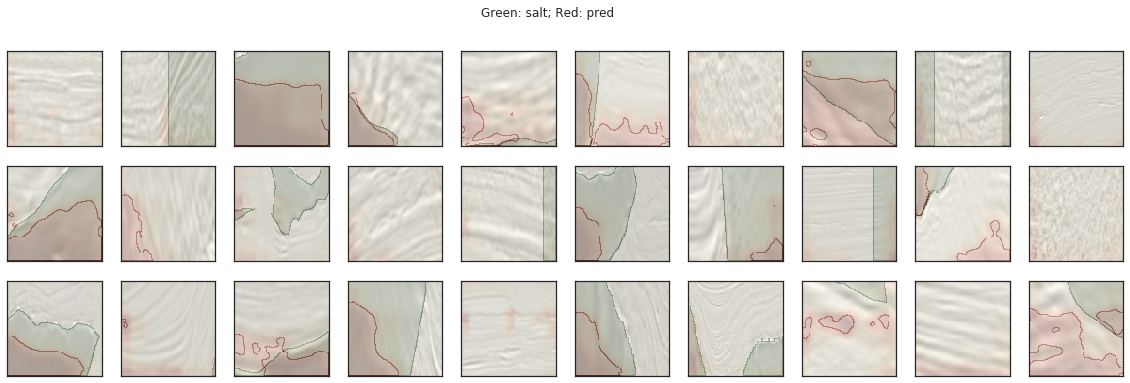

In [15]:
show_images(dataset, unprocess_fn=downsample, model=model)

In [14]:
submission_path = SUBMISSIONS_PATH + model_name.replace('.pt', '.csv')
print(submission_path)
threshold_best = 0.5

predictions = test(model, dataset, batch_size=25)
predictions = np.array([downsample(pred) for pred in predictions.data.cpu().numpy()[:, 0, :, :]])
binary_predictions = (predictions > threshold_best).astype(int)

all_masks = rle_encoding(binary_predictions)

submit = pd.DataFrame([[rec.split('-')[1] for rec in dataset.test], all_masks]).T
submit.columns = ['id', 'rle_mask']
submit.to_csv(submission_path, index = False)

/home/gazay/submissions/salt/2018-10-02-061420_d378df5_vanilla-u_net_st01_82_0.2032_0.7526.csv


/home/gazay/anaconda3/lib/python3.6/site-packages/torchbearer/torchbearer.py:36: UserWarning: torchbearer.Model and all of its attributes are deprecated as of version 0.2.0. Use torchbearer.Trial instead
  UserWarning)
0/1(p): 100%|██████████| 720/720 [00:44<00:00, 16.06it/s]


In [16]:
!kaggle c submit -f {submission_path.replace(':', '\:')} -m '{submission_path}' -c tgs-salt-identification-challenge

Successfully submitted to TGS Salt Identification Challenge